In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, default_data_collator, \
    DataCollatorForLanguageModeling
from datasets import load_dataset
from arguments import DataTrainingArguments, ModelArguments, TrainingArguments
from collections import defaultdict
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import color_idx, room_idx

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base', legacy=True)

# Initialize the data arguments
data_args = DataTrainingArguments(
    datasets='floorplan',
    data_dir=None,
    train_split='combined',
    max_seq_length=512,
    max_output_seq_length=512,
    max_seq_length_eval=512,
    max_output_seq_length_eval=512,
    exp='full',
    boundary_in_where='Encoder'
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model = T5ForConditionalGeneration.from_pretrained('output/checkpoint-22780')

In [5]:
# Example usage
input_sentence = "Balcony 1 is about 8 foot X 2 foot.  This is located right off of the kitchen. Balcony 2 is about 10 foot X 3 foot.  This is facing north of the house. The bathroom is about 8 foot X 6 foot.  It is located between the living room and the kitchen. Common room 1 is about 10 foot X 12 foot.  The common rooms are located diagonal from each other. Common room 2 is about 10 foot X 10 foot.  The common rooms are located diagonal from each other. The kitchen is a 10 foot X 10 foot room.  It looks like it is opened up to the living room. The living room is located on the east side of the house.  It is shaped like a \"T\" and it's the biggest room.  It is approximately 14 feet X 32 feet.  Each room that you come out of you will enter the living room. The master is about 10 feet X 15 feet.  It is located far west of the house.It is a rectangle shape."
input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids

# Generate output
output_ids = model.generate(input_ids, max_new_tokens=512)
output_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Output sentence:", output_sentence)

Output sentence: [ bathroom | x coordinate = 154 | y coordinate = 135 | height = 34 | width = 20 ] [ kitchen | x coordinate = 192 | y coordinate = 165 | height = 33 | width = 30 ] [ balcony 2 | x coordinate = 58 | y coordinate = 175 | height = 20 | width = 51 ] [ common room 1 | x coordinate = 154 | y coordinate = 89 | height = 34 | width = 47 ] [ master room | x coordinate = 102 | y coordinate = 77 | height = 59 | width = 42 ] [ living room | x coordinate = 134 | y coordinate = 152 | height = 123 | width = 94 ] [ balcony 1 | x coordinate = 197 | y coordinate = 133 | height = 33 | width = 12 ] [ common room 2 | x coordinate = 93 | y coordinate = 124 | height = 38 | width = 42 ]


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [7]:
import os

dir_path = 'data/annotated_imgs'
file_names = os.listdir(dir_path)
target_file_names = [file_name.split('.')[0] for file_name in file_names]

In [8]:
from datasets import load_dataset

floorplan_dataset = load_dataset(data_args.datasets, data_args, split=data_args.train_split,
                                 max_input_length=data_args.max_seq_length,
                                 max_output_length=data_args.max_output_seq_length,
                                 tokenizer=tokenizer, seed=1)

In [9]:
len(floorplan_dataset)

4554

In [12]:
dir_path = 'data/predicted_wob_imgs'
file_names = os.listdir(dir_path)
done_file_names = [file_name.split('.')[0] for file_name in file_names]

In [14]:
def generate_output_sentence(idx):
    example = floorplan_dataset.get_example(idx)
    input_sentence = ' '.join(example.tokens)
    input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_new_tokens=512)
    output_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return example, output_sentence, None


def render_floor_plan_by_id(idx, with_boundary=True):
    example, output_sentence, predicted_index = generate_output_sentence(idx)
    if example is None:
        return None, None
    image_id = vars(example)['image_id']

    gt_boxes = defaultdict(list)
    for room in example.rooms:
        gt_x, gt_y, gt_h, gt_w = room.x, room.y, room.h, room.w
        gt_box = [
            [int(gt_x - gt_h / 2), int(gt_y - gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y - gt_w / 2)],
            [int(gt_x - gt_h / 2), int(gt_y + gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y + gt_w / 2)]
        ]
        gt_boxes[room.type] = gt_box
    res = floorplan_dataset.output_format.run_inference(example, output_sentence, predicted_index)
    predicted_rooms_by_name, predicted_rooms, raw_predicted_relations, wrong_reconstruction, format_error, label_error = res

    predicted_attribute = defaultdict()
    for attribute_tuple in raw_predicted_relations:
        attribute_type, value, room_tuple, room_type = attribute_tuple
        if room_type not in predicted_attribute:
            predicted_attribute[room_type] = defaultdict()
        try:
            value = int(value)
        except:
            value = 128
        predicted_attribute[room_type][attribute_type] = value

    # TODO: examine the predicted_attribute patterns
    correct_attributes = ['x coordinate', 'y coordinate', 'height', 'width']
    wrong_room = []
    for room_type in predicted_attribute:
        if set(list(predicted_attribute[room_type].keys())) != set(correct_attributes):
            print('wrong output format:')
            print(predicted_attribute[room_type])
            wrong_room.append(room_type)
    for wrong_r in wrong_room:
        predicted_attribute.pop(wrong_r)

    predicted_boxes = defaultdict()
    for room in predicted_attribute:
        predicted_boxes[room] = [
            [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
             int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
            [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
             int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
            [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
             int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)],
            [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
             int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)]
        ]

    for room in predicted_boxes:
        y_min = predicted_boxes[room][0][1]
        x_min = predicted_boxes[room][0][0]
        y_max = predicted_boxes[room][3][1]
        x_max = predicted_boxes[room][3][0]
        predicted_boxes[room] = (y_min, x_min, y_max, x_max)

    # render_image_
    image_height = 256
    image_width = 256
    number_of_color_channels = 3
    background_color = (255, 255, 255)
    predicted_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    boundary_color = [0, 0, 0]

    living = defaultdict()
    common = defaultdict()
    master = defaultdict()
    balcony = defaultdict()
    bathroom = defaultdict()
    kitchen = defaultdict()
    storage = defaultdict()
    dining = defaultdict()
    for room in predicted_boxes:
        if room.startswith('living'):
            living[room] = predicted_boxes[room]
        elif room.startswith('common'):
            common[room] = predicted_boxes[room]
        elif room.startswith('master'):
            master[room] = predicted_boxes[room]
        elif room.startswith('balcony'):
            balcony[room] = predicted_boxes[room]
        elif room.startswith('bathroom'):
            bathroom[room] = predicted_boxes[room]
        elif room.startswith('kitchen'):
            kitchen[room] = predicted_boxes[room]
        elif room.startswith('storage'):
            storage[room] = predicted_boxes[room]
        elif room.startswith('dining'):
            dining[room] = predicted_boxes[room]

    room_type_list = [living, common, master, balcony, bathroom, kitchen, storage, dining]
    for room_type in room_type_list:
        for room in room_type:
            left_top_pr = (room_type[room][0], room_type[room][1])
            right_bt_pr = (room_type[room][2], room_type[room][3])

            color = color_idx[room_idx[room]]
            # draw room on predicted image
            cv2.rectangle(predicted_image, left_top_pr, right_bt_pr, color, -1)

    if with_boundary:
        for boundary_pixel in example.boundary:
            predicted_image[boundary_pixel[0], boundary_pixel[1]] = boundary_color

    return predicted_image, image_id

In [15]:
img, img_id = render_floor_plan_by_id(0)

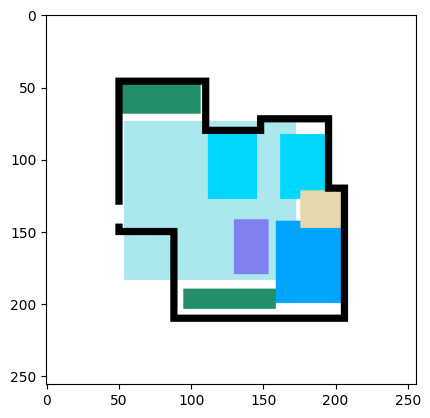

In [16]:
plt.imshow(img)
plt.show()

In [17]:
save_dir = 'data/predicted_wb_imgs/'

dataset_length = len(floorplan_dataset)

for idx in range(dataset_length):
    try:
        img, img_id = render_floor_plan_by_id(idx)
        if img is not None:
            if img_id in target_file_names:
                cv2.imwrite(os.path.join(save_dir, f'{img_id}.png'), img)
                print(f'{img_id} saved | {round((idx + 1) / dataset_length * 100, 2)}%')
    except Exception as e:
        print(f'{e}: {idx} failed')

50383 saved | 0.02%
21701 saved | 0.07%
22743 saved | 0.09%
1997 saved | 0.11%
27519 saved | 0.15%
8151 saved | 0.2%
17584 saved | 0.29%
66347 saved | 0.33%
53427 saved | 0.4%
8439 saved | 0.44%
73135 saved | 0.46%
31889 saved | 0.48%
66890 saved | 0.55%
65743 saved | 0.57%
28958 saved | 0.66%
23716 saved | 0.68%
36396 saved | 0.7%
13436 saved | 0.83%
46152 saved | 0.88%
6718 saved | 0.9%
36275 saved | 0.92%
68227 saved | 0.94%
51643 saved | 0.97%
49467 saved | 1.01%
6219 saved | 1.03%
23935 saved | 1.05%
59307 saved | 1.1%
13249 saved | 1.16%
71656 saved | 1.21%
11745 saved | 1.23%
71908 saved | 1.3%
49644 saved | 1.34%
64235 saved | 1.36%
25949 saved | 1.45%
43861 saved | 1.47%
31653 saved | 1.49%
3500 saved | 1.54%
13235 saved | 1.56%
66903 saved | 1.69%
53363 saved | 1.73%
7935 saved | 1.76%
76010 saved | 1.78%
62770 saved | 1.8%
31163 saved | 1.84%
10047 saved | 1.87%
51463 saved | 1.91%
59676 saved | 1.93%
41897 saved | 2.0%
8633 saved | 2.02%
8331 saved | 2.04%
13875 saved | 2.1

In [18]:
save_dir = 'data/predicted_wob_imgs/'

dataset_length = len(floorplan_dataset)

for idx in range(dataset_length):
    try:
        img, img_id = render_floor_plan_by_id(idx, with_boundary=False)
        if img_id in target_file_names:
            cv2.imwrite(os.path.join(save_dir, f'{img_id}.png'), img)
            print(f'{img_id} saved | {round((idx + 1) / dataset_length * 100, 2)}%')
    except:
        print(f'{idx} failed')

50383 saved | 0.02%
21701 saved | 0.07%
22743 saved | 0.09%
1997 saved | 0.11%
27519 saved | 0.15%
8151 saved | 0.2%
17584 saved | 0.29%
66347 saved | 0.33%
53427 saved | 0.4%
8439 saved | 0.44%
73135 saved | 0.46%
31889 saved | 0.48%
66890 saved | 0.55%
65743 saved | 0.57%
28958 saved | 0.66%
23716 saved | 0.68%
36396 saved | 0.7%
13436 saved | 0.83%
46152 saved | 0.88%
6718 saved | 0.9%
36275 saved | 0.92%
68227 saved | 0.94%
51643 saved | 0.97%
49467 saved | 1.01%
6219 saved | 1.03%
23935 saved | 1.05%
59307 saved | 1.1%
13249 saved | 1.16%
71656 saved | 1.21%
11745 saved | 1.23%
71908 saved | 1.3%
49644 saved | 1.34%
64235 saved | 1.36%
25949 saved | 1.45%
43861 saved | 1.47%
31653 saved | 1.49%
3500 saved | 1.54%
13235 saved | 1.56%
66903 saved | 1.69%
53363 saved | 1.73%
7935 saved | 1.76%
76010 saved | 1.78%
62770 saved | 1.8%
31163 saved | 1.84%
10047 saved | 1.87%
51463 saved | 1.91%
59676 saved | 1.93%
41897 saved | 2.0%
8633 saved | 2.02%
8331 saved | 2.04%
13875 saved | 2.1

In [ ]:
!zip -r data/predicted_wb_imgs.zip data/predicted_wb_imgs
!zip -r data/predicted_wob_imgs.zip data/predicted_wob_imgs
# !zip -r data/annotated_imgs.zip data/annotated_imgs

In [6]:
# random_idx = random.choice(range(len(floorplan_dataset)))
random_idx = 0
example, output_sentence, predicted_index = generate_output_sentence(random_idx)
print(floorplan_dataset.input_format.format_input(example, multitask=False))
print("Output sentence:", output_sentence)

Balcony 1 is located on the north side and next to the living room . size is 12 3 Balcony 2 is located on the south side and near to the living and kitchen . size is 14 2 The bathroom is located in the east side and between the master room and common2 room . size is 8 8 Common room 1 is located in the north side and the next to the common2 . size is 8 10 Common room 2 is located on the north east corner and next to bath room . size is 10 12 The kitchen is located on the south side and near balcony2 and master room . size is 6 10 The living room is located on the west side and west facing . its unsized room . size is 20 32 The master room is located on the south east corner and next to the kitchen . size is 12 16
Output sentence: [ common room 1 | x coordinate = 87 | y coordinate = 132 | height = 44 | width = 33 ] [ balcony 2 | x coordinate = 207 | y coordinate = 124 | height = 12 | width = 61 ] [ bathroom | x coordinate = 126 | y coordinate = 188 | height = 29 | width = 30 ] [ common r

In [90]:
vars(example)['image_id']

'13613'

In [7]:
gt_boxes = defaultdict(list)
for room in example.rooms:
    gt_x, gt_y, gt_h, gt_w = room.x, room.y, room.h, room.w
    gt_box = [
        [int(gt_x - gt_h / 2), int(gt_y - gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y - gt_w / 2)],
        [int(gt_x - gt_h / 2), int(gt_y + gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y + gt_w / 2)]
    ]
    gt_boxes[room.type] = gt_box

In [8]:
res = floorplan_dataset.output_format.run_inference(example, output_sentence, predicted_index)
predicted_rooms_by_name, predicted_rooms, raw_predicted_relations, wrong_reconstruction, format_error, label_error = res

In [9]:
predicted_attribute = defaultdict()
for attribute_tuple in raw_predicted_relations:
    attribute_type, value, room_tuple, room_type = attribute_tuple
    if room_type not in predicted_attribute:
        predicted_attribute[room_type] = defaultdict()
    try:
        value = int(value)
    except:
        value = 128
    predicted_attribute[room_type][attribute_type] = value

In [10]:
# TODO: examine the predicted_attribute patterns
correct_attributes = ['x coordinate', 'y coordinate', 'height', 'width']
wrong_room = []
for room_type in predicted_attribute:
    if set(list(predicted_attribute[room_type].keys())) != set(correct_attributes):
        print('wrong output format:')
        print(predicted_attribute[room_type])
        wrong_room.append(room_type)
for wrong_r in wrong_room:
    predicted_attribute.pop(wrong_r)

In [11]:
all_gt_rooms = [room.type for room in example.rooms]
predicted_boxes = defaultdict()
for room in predicted_attribute:
    predicted_boxes[room] = [
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)]
    ]


In [13]:
example.rooms

[Room(type='common room 1', x=105, y=129, h=44, w=33, x_min=83, y_min=113, x_max=126, y_max=145, near_x_min=-1, near_y_min=-1, near_x_max=123, near_y_max=-1, relation=['bathroom'], location='south side', size='100', aspect_ratio='3 over 4', private='False'),
 Room(type='bathroom', x=135, y=190, h=25, w=28, x_min=123, y_min=176, x_max=147, y_max=203, near_x_min=126, near_y_min=-1, near_x_max=-1, near_y_max=-1, relation=['common room 1', 'common room 2'], location='north east corner', size='50', aspect_ratio='9 over 8', private='False'),
 Room(type='master room', x=180, y=181, h=55, w=45, x_min=153, y_min=159, x_max=207, y_max=203, near_x_min=-1, near_y_min=-1, near_x_max=-1, near_y_max=-1, relation=[], location='north east corner', size='150', aspect_ratio='9 over 11', private='False'),
 Room(type='balcony 1', x=59, y=80, h=21, w=55, x_min=49, y_min=53, x_max=69, y_max=107, near_x_min=-1, near_y_min=-1, near_x_max=-1, near_y_max=-1, relation=[], location='south west corner', size='50', 

In [12]:
all_gt_rooms

['common room 1',
 'bathroom',
 'master room',
 'balcony 1',
 'kitchen',
 'common room 2',
 'living room',
 'balcony 2']

In [70]:
for room in gt_boxes:
    y_min = gt_boxes[room][0][1]
    x_min = gt_boxes[room][0][0]
    y_max = gt_boxes[room][3][1]
    x_max = gt_boxes[room][3][0]
    gt_boxes[room] = (y_min, x_min, y_max, x_max)

In [71]:
for room in predicted_boxes:
    y_min = predicted_boxes[room][0][1]
    x_min = predicted_boxes[room][0][0]
    y_max = predicted_boxes[room][3][1]
    x_max = predicted_boxes[room][3][0]
    predicted_boxes[room] = (y_min, x_min, y_max, x_max)

In [72]:
# render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes, output_dir)

In [73]:
def render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes):
    image_height = 256
    image_width = 256
    number_of_color_channels = 3
    background_color = (255, 255, 255)
    gt_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    predicted_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    boundary_color = [0, 0, 0]

    left_boundary = int(example.boundary_tokens[1])

    # Calculate the minimum and maximum x and y coordinates
    min_x = min(box[1] for box in predicted_boxes.values())
    min_y = min(box[0] for box in predicted_boxes.values())
    max_x = max(box[3] for box in predicted_boxes.values())
    max_y = max(box[2] for box in predicted_boxes.values())

    # Calculate the range of x and y coordinates
    range_x = max_x - min_x
    range_y = max_y - min_y

    # Scale factor for x and y coordinates
    scale_x = image_width / range_x
    scale_y = image_height / range_y

    living = defaultdict()
    common = defaultdict()
    master = defaultdict()
    balcony = defaultdict()
    bathroom = defaultdict()
    kitchen = defaultdict()
    storage = defaultdict()
    dining = defaultdict()
    for room in predicted_boxes:
        if room.startswith('living'):
            living[room] = predicted_boxes[room]
        elif room.startswith('common'):
            common[room] = predicted_boxes[room]
        elif room.startswith('master'):
            master[room] = predicted_boxes[room]
        elif room.startswith('balcony'):
            balcony[room] = predicted_boxes[room]
        elif room.startswith('bathroom'):
            bathroom[room] = predicted_boxes[room]
        elif room.startswith('kitchen'):
            kitchen[room] = predicted_boxes[room]
        elif room.startswith('storage'):
            storage[room] = predicted_boxes[room]
        elif room.startswith('dining'):
            dining[room] = predicted_boxes[room]
    room_type_list = [living, common, master, balcony, bathroom, kitchen, storage, dining]
    for room_type in room_type_list:
        for room in room_type:
            left_top_pr = (room_type[room][0], room_type[room][1])
            right_bt_pr = (room_type[room][2], room_type[room][3])

            color = color_idx[room_idx[room]]
            # draw room on predicted image
            cv2.rectangle(predicted_image, left_top_pr, right_bt_pr, color, -1)

    # Draw the directions
    # height, width, _ = predicted_image.shape
    #
    # cv2.putText(predicted_image, "South", (int(width/2), height-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "North", (int(width/2), 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "West", (10, int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "East", (width-50, int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

    for boundary_pixel in example.boundary:
        predicted_image[boundary_pixel[0], boundary_pixel[1]] = boundary_color

    return predicted_image

In [74]:
render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [75]:
import matplotlib.patches as mpatches


def render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes):
    # Render the image as before
    image = render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Add direction labels for the entire floor plan
    plt.text(0.5, 0.02, "South", fontsize=10, ha='center', va='bottom', color='red', transform=plt.gca().transAxes)
    plt.text(0.5, 0.98, "North", fontsize=10, ha='center', va='top', color='red', transform=plt.gca().transAxes)
    plt.text(0.02, 0.5, "West", fontsize=10, ha='left', va='center', color='red', transform=plt.gca().transAxes)
    plt.text(0.98, 0.5, "East", fontsize=10, ha='right', va='center', color='red', transform=plt.gca().transAxes)

    # Create a legend
    patches = [mpatches.Patch(color=np.array(color_idx[room_idx[room]]) / 255., label=room) for room in all_gt_rooms]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()

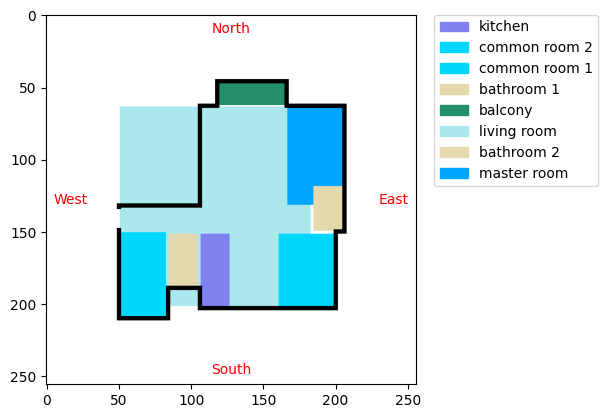

In [76]:
render_image_with_legend(example, gt_boxes, all_gt_rooms, gt_boxes)

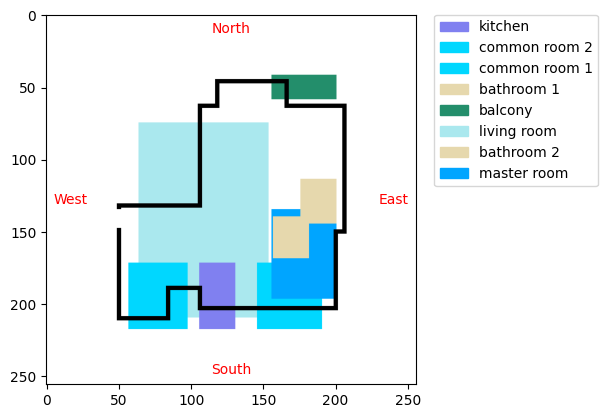

In [77]:
render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes)

In [26]:
predicted_boxes

defaultdict(None,
            {'common room': (157, 62, 199, 113),
             'kitchen': (63, 62, 88, 113),
             'bathroom': (63, 101, 88, 125),
             'master room': (70, 127, 112, 185),
             'balcony': (172, 127, 201, 141),
             'living room': (99, 70, 175, 185)})

In [58]:
import json

with open('data/floorplan/floorplan_eval.json') as f:
    data = json.load(f)

<function dict.keys>

In [59]:
data[0]

{'annotated_strings': 'Balcony location:South Side, Relationship:the location: Next to Living,  Area:50 sqrt feet   Sides: 10 feet width and 5 feet length.. Bathroom location:East side , Relationship:the location: Between kitchen and master,  Area:25 sqrt feet   Sides: 5 feet width and 5 feet length.. Comon room 1 location:North side, Relationship:the location: Next to Com2 and Kitichen,  Area:100 sqrt feet   Sides: 10 feet width and 10 feet length.. Comon room 2 location:North West Corner, Relationship:the location: Next to Living,  Area:150 sqrt feet   Sides: 10 feet width and 15 feet length.. Kitchen location:North Side, Relationship:the location: Next to bath and Com1,  Area:50 sqrt feet   Sides: 5 feet width and 10 feet length.. Living room location: West side, Relationship:the location: Between Com2 and Balcony,  Area:450 sqrt feet   Sides: 15 feet width and 30 feet length. Master room location:South est corner , Relationship:the location: Next to living ,  Area:200 sqrt feet   S

In [63]:
dict(data[0])['img_id']

'3326'

In [8]:
import numpy as np
import matplotlib.patches as mpatches
from utils import render_floor_plan_by_output_sentence
from utils import color_idx, room_idx

def render_image_with_legend(output_sentence_):
    # Render the image as before
    image, room_list = render_floor_plan_by_output_sentence(output_sentence_)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Add direction labels for the entire floor plan
    plt.text(0.5, 0.02, "South", fontsize=10, ha='center', va='bottom', color='red', transform=plt.gca().transAxes)
    plt.text(0.5, 0.98, "North", fontsize=10, ha='center', va='top', color='red', transform=plt.gca().transAxes)
    plt.text(0.02, 0.5, "West", fontsize=10, ha='left', va='center', color='red', transform=plt.gca().transAxes)
    plt.text(0.98, 0.5, "East", fontsize=10, ha='right', va='center', color='red', transform=plt.gca().transAxes)

    # Create a legend
    patches = [mpatches.Patch(color=np.array(color_idx[room_idx[room]]) / 255., label=room) for room in room_list]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()

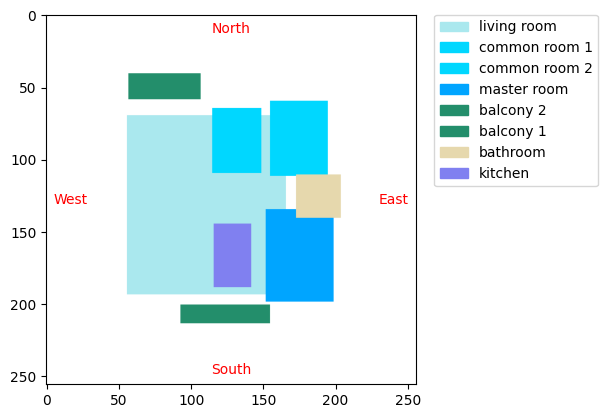

In [9]:
output_sentence_ = "[ common room 1 | x coordinate = 87 | y coordinate = 132 | height = 44 | width = 33 ] [ balcony 2 | x coordinate = 207 | y coordinate = 124 | height = 12 | width = 61 ] [ bathroom | x coordinate = 126 | y coordinate = 188 | height = 29 | width = 30 ] [ common room 2 | x coordinate = 86 | y coordinate = 175 | height = 51 | width = 39 ] [ kitchen | x coordinate = 167 | y coordinate = 129 | height = 43 | width = 25 ] [ balcony 1 | x coordinate = 50 | y coordinate = 82 | height = 17 | width = 49 ] [ living room | x coordinate = 132 | y coordinate = 111 | height = 123 | width = 109 ] [ master room | x coordinate = 167 | y coordinate = 175 | height = 63 | width = 46 ]"
render_image_with_legend(output_sentence_)